In [20]:
!git pull https://github.com/Lolleeee/MIEEG

From https://github.com/Lolleeee/MIEEG
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


In [1]:
!git clone https://github.com/Lolleeee/MIEEG
import os 
os.chdir("MIEEG")

Cloning into 'MIEEG'...
remote: Enumerating objects: 1108, done.
remote: Counting objects: 100% (259/259), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 1108 (delta 182), reused 153 (delta 86), pack-reused 849 (from 1)
Receiving objects: 100% (1108/1108), 41.09 MiB | 49.09 MiB/s, done.
Resolving deltas: 100% (734/734), done.


In [5]:
from packages.train.training import train_model
from packages.io.file_loader import get_data_loaders
import torch
import os

from packages.data_objects.dataset import TorchDataset, CustomTestDataset

dataset_path = "/kaggle/input/0-5subset-datanooverlap"
# Dummy training loop

dataset = TorchDataset(root_folder=dataset_path, chunk_size=64)

train_loader, val_loader, _ = get_data_loaders(dataset, sets_size={'train': 0.7, 'val': 0.3, 'test': 0.}, norm_axes=(0, 1, 5), batch_size = 64)
# norm_params = train_loader.dataset.dataset._norm_params

Calculating global parameters: 100%|██████████| 87/87 [00:09<00:00,  8.82it/s]

Calculated mean shape: torch.Size([1, 25, 7, 5, 1]), std shape: torch.Size([1, 25, 7, 5, 1])


In [41]:
optimizer = torch.optim.AdamW
from packages.models.vqae import SequenceProcessor
from packages.models.vqae_skip import VQVAE
from packages.train.loss import VQVAELoss, SequenceVQVAELoss
model = SequenceProcessor(chunk_shape=(25, 7, 5, 64), embedding_dim=128, codebook_size=512, use_quantizer=False)
model.chunk_ae = VQVAE(
    in_channels = 25,
    input_spatial=(7, 5, 64),
    embedding_dim=128,
    codebook_size=512,
    use_quantizer=False,
    use_skip_connections=False,
    num_downsample_stages=3,
    skip_strength=0.001, 
    skip_mode='add',
    commitment_cost=1,
    decay=0.5)
#model.load_state_dict(torch.load("/kaggle/working/MIEEG/model_backups/best_model_epoch_21.pt"))
criterion = SequenceVQVAELoss(
    recon_loss_type='mse',
    recon_weight=1.0
)

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class SequenceVQVAELossPlus(nn.Module):
    """
    Loss function for SequenceProcessor with bottleneck regularization.
    """
    def __init__(
        self,
        recon_loss_type='mse',
        recon_weight=1.0,
        perceptual_weight=0.1,
        bottleneck_var_weight=1.0,      # NEW: Force variance in embeddings
        bottleneck_cov_weight=0.5,      # NEW: Force decorrelation
        min_variance=0.1                # NEW: Minimum per-dimension variance
    ):
        super().__init__()
        
        self.recon_loss_type = recon_loss_type
        self.recon_weight = recon_weight
        self.perceptual_weight = perceptual_weight
        self.bottleneck_var_weight = bottleneck_var_weight
        self.bottleneck_cov_weight = bottleneck_cov_weight
        self.min_variance = min_variance
    
    def _perceptual_loss(self, x, x_recon):
        """Perceptual loss for sequence of chunks"""
        batch_size, num_chunks = x.shape[:2]
        x_flat = x.view(-1, *x.shape[2:])
        x_recon_flat = x_recon.view(-1, *x_recon.shape[2:])
        
        def compute_gradients(tensor):
            dx = tensor[:, :, 1:, :, :] - tensor[:, :, :-1, :, :]
            dy = tensor[:, :, :, 1:, :] - tensor[:, :, :, :-1, :]
            dt = tensor[:, :, :, :, 1:] - tensor[:, :, :, :, :-1]
            return dx, dy, dt
        
        x_grads = compute_gradients(x_flat)
        recon_grads = compute_gradients(x_recon_flat)
        
        loss = sum(F.l1_loss(g1, g2) for g1, g2 in zip(x_grads, recon_grads))
        return loss / 3.0

    def _bottleneck_variance_loss(self, embeddings):
        """
        Penalize low variance in embeddings to prevent collapse.
        
        Args:
            embeddings: (B * num_chunks, embedding_dim) flattened embeddings
        """
        # Compute per-dimension variance
        z_mean = embeddings.mean(dim=0)
        z_var = ((embeddings - z_mean) ** 2).mean(dim=0)
        
        # Penalize variance below threshold
        var_loss = torch.mean(torch.relu(self.min_variance - z_var))
        
        return var_loss
    
    def _bottleneck_decorrelation_loss(self, embeddings):
        """
        Penalize correlation between embedding dimensions.
        Forces dimensions to be independent.
        
        Args:
            embeddings: (B * num_chunks, embedding_dim) flattened embeddings
        """
        # Center the embeddings
        z_mean = embeddings.mean(dim=0)
        z_centered = embeddings - z_mean
        
        # Compute correlation matrix
        z_std = z_centered.std(dim=0, keepdim=True) + 1e-8
        z_normalized = z_centered / z_std
        
        correlation = torch.mm(z_normalized.t(), z_normalized) / embeddings.size(0)
        
        # Penalize off-diagonal correlations
        identity = torch.eye(embeddings.size(1), device=embeddings.device)
        decorr_loss = torch.mean((correlation - identity) ** 2)
        
        return decorr_loss

    def forward(self, outputs, chunks, embeddings=None):
        """
        Compute total loss for sequence.
        
        Args:
            outputs: (chunks_recon, vq_loss, indices) from model
            chunks: Original chunks (B, num_chunks, C, H, W, T)
            embeddings: (B, num_chunks, embedding_dim) - REQUIRED for bottleneck reg
            
        Returns:
            loss: Total loss (scalar)
            loss_dict: Dictionary of individual loss components
        """
        chunks_recon, vq_loss, _ = outputs
        
        # Reconstruction loss
        if self.recon_loss_type == 'mse':
            recon_loss = F.mse_loss(chunks_recon, chunks)
        elif self.recon_loss_type == 'l1':
            recon_loss = F.l1_loss(chunks_recon, chunks)
        elif self.recon_loss_type == 'perceptual':
            recon_loss = F.mse_loss(chunks_recon, chunks)
            perc_loss = self._perceptual_loss(chunks, chunks_recon)
            recon_loss = recon_loss + self.perceptual_weight * perc_loss
        else:
            raise ValueError(f"Unknown recon_loss_type: {self.recon_loss_type}")
        
        # Bottleneck regularization (if embeddings provided)
        bottleneck_loss = 0.0
        if embeddings is not None:
            # Flatten embeddings: (B, num_chunks, D) -> (B*num_chunks, D)
            embeddings_flat = embeddings.view(-1, embeddings.size(-1))
            
            # Variance loss: prevent dimensions from collapsing to zero
            var_loss = self._bottleneck_variance_loss(embeddings_flat)
            
            # Decorrelation loss: prevent dimensions from being correlated
            decorr_loss = self._bottleneck_decorrelation_loss(embeddings_flat)
            
            bottleneck_loss = (
                self.bottleneck_var_weight * var_loss +
                self.bottleneck_cov_weight * decorr_loss
            )
        
        # Total loss
        total_loss = (
            self.recon_weight * recon_loss + 
            vq_loss + 
            bottleneck_loss
        )
        
        # Return detailed loss breakdown for monitoring
        loss_dict = {
            'total': total_loss.item(),
            'recon': recon_loss.item(),
            'vq': vq_loss.item() if isinstance(vq_loss, torch.Tensor) else vq_loss,
            'bottleneck': bottleneck_loss.item() if isinstance(bottleneck_loss, torch.Tensor) else 0.0
        }
        
        return total_loss
criterion = SequenceVQVAELossPlus(
    recon_loss_type='mse',
    recon_weight=1.0
)

In [42]:
config = {
    'lr': 1e-3,
    'weight_decay': 1e-3,
    'epochs': 300,
    #'EarlyStopping' : {'patience': 20, 'min_delta': 0.01},
    'BackupManager': {'backup_interval': 10, 'backup_path': './model_backups'},
    'ReduceLROnPlateau': {'mode': 'min', 'patience': 40, 'factor': 0.0},
    'history_plot': {'plot_type': 'extended', 'save_path': './training_history'},
    'grad_clip': 1.0,
    'use_amp': False,
    #'grad_logging_interval' : 10,
    'asym_lr': None
}
train_model(model, train_loader=train_loader, val_loader=val_loader, loss_criterion=criterion, optimizer=optimizer, config=config, metrics={})

Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.8834
[INFO] Val Loss: 0.8482
[INFO] Best model saved at epoch 1 with metric 0.8482


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.8051
[INFO] Val Loss: 0.8189
[INFO] Best model saved at epoch 2 with metric 0.8189


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.7860
[INFO] Val Loss: 0.7957
[INFO] Best model saved at epoch 3 with metric 0.7957


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.7696
[INFO] Val Loss: 0.7801
[INFO] Best model saved at epoch 4 with metric 0.7801


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.7546
[INFO] Val Loss: 0.7708
[INFO] Best model saved at epoch 5 with metric 0.7708


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.7396
[INFO] Val Loss: 0.7465
[INFO] Best model saved at epoch 6 with metric 0.7465


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.7273
[INFO] Val Loss: 0.7365
[INFO] Best model saved at epoch 7 with metric 0.7365


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.7163
[INFO] Val Loss: 0.7539


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.7147
[INFO] Val Loss: 0.7154
[INFO] Best model saved at epoch 9 with metric 0.7154


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6978
[INFO] Val Loss: 0.7096
[INFO] Best model saved at epoch 10 with metric 0.7096


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6918
[INFO] Val Loss: 0.7022
[INFO] Best model saved at epoch 11 with metric 0.7022


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6870
[INFO] Val Loss: 0.6963
[INFO] Best model saved at epoch 12 with metric 0.6963


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6770
[INFO] Val Loss: 0.6855
[INFO] Best model saved at epoch 13 with metric 0.6855


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6718
[INFO] Val Loss: 0.6817
[INFO] Best model saved at epoch 14 with metric 0.6817


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6656
[INFO] Val Loss: 0.6755
[INFO] Best model saved at epoch 15 with metric 0.6755


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6610
[INFO] Val Loss: 0.6699
[INFO] Best model saved at epoch 16 with metric 0.6699


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6568
[INFO] Val Loss: 0.6628
[INFO] Best model saved at epoch 17 with metric 0.6628


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6515
[INFO] Val Loss: 0.6609
[INFO] Best model saved at epoch 18 with metric 0.6609


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6461
[INFO] Val Loss: 0.6562
[INFO] Best model saved at epoch 19 with metric 0.6562


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6445
[INFO] Val Loss: 0.6520
[INFO] Best model saved at epoch 20 with metric 0.6520


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6408
[INFO] Val Loss: 0.6512
[INFO] Best model saved at epoch 21 with metric 0.6512


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6366
[INFO] Val Loss: 0.6447
[INFO] Best model saved at epoch 22 with metric 0.6447


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6348
[INFO] Val Loss: 0.6472


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6333
[INFO] Val Loss: 0.6465


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6291
[INFO] Val Loss: 0.6366
[INFO] Best model saved at epoch 25 with metric 0.6366


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6243
[INFO] Val Loss: 0.6367


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6210
[INFO] Val Loss: 0.6315
[INFO] Best model saved at epoch 27 with metric 0.6315


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6192
[INFO] Val Loss: 0.6320


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6175
[INFO] Val Loss: 0.6285
[INFO] Best model saved at epoch 29 with metric 0.6285


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6150
[INFO] Val Loss: 0.6255
[INFO] Best model saved at epoch 30 with metric 0.6255


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6116
[INFO] Val Loss: 0.6232
[INFO] Best model saved at epoch 31 with metric 0.6232


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6107
[INFO] Val Loss: 0.6241


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6099
[INFO] Val Loss: 0.6204
[INFO] Best model saved at epoch 33 with metric 0.6204


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6083
[INFO] Val Loss: 0.6212


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6074
[INFO] Val Loss: 0.6243


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6063
[INFO] Val Loss: 0.6166
[INFO] Best model saved at epoch 36 with metric 0.6166


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6017
[INFO] Val Loss: 0.6163
[INFO] Best model saved at epoch 37 with metric 0.6163


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.6028
[INFO] Val Loss: 0.6152
[INFO] Best model saved at epoch 38 with metric 0.6152


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.5993
[INFO] Val Loss: 0.6104
[INFO] Best model saved at epoch 39 with metric 0.6104


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.5973
[INFO] Val Loss: 0.6097
[INFO] Best model saved at epoch 40 with metric 0.6097


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.5959
[INFO] Val Loss: 0.6085
[INFO] Best model saved at epoch 41 with metric 0.6085


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.5954
[INFO] Val Loss: 0.6053
[INFO] Best model saved at epoch 42 with metric 0.6053


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.5916
[INFO] Val Loss: 0.6049
[INFO] Best model saved at epoch 43 with metric 0.6049


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.5917
[INFO] Val Loss: 0.6041
[INFO] Best model saved at epoch 44 with metric 0.6041


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.5887
[INFO] Val Loss: 0.6014
[INFO] Best model saved at epoch 45 with metric 0.6014


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.5853
[INFO] Val Loss: 0.5980
[INFO] Best model saved at epoch 46 with metric 0.5980


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.5844
[INFO] Val Loss: 0.5974
[INFO] Best model saved at epoch 47 with metric 0.5974


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.5828
[INFO] Val Loss: 0.5958
[INFO] Best model saved at epoch 48 with metric 0.5958


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.5802
[INFO] Val Loss: 0.5956
[INFO] Best model saved at epoch 49 with metric 0.5956


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

[INFO] Train Loss: 0.5792
[INFO] Val Loss: 0.5922
[INFO] Best model saved at epoch 50 with metric 0.5922


Training Batches:   0%|          | 0/87 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [43]:
criterion = SequenceVQVAELoss(
    recon_loss_type='mse',
    recon_weight=1.0)    
model.eval()
model.to(device='cuda')
with torch.no_grad():
    for batch in val_loader:
        batch = batch.to(device='cuda')
        out = model(batch)
        emb = model.encode_sequence(batch)
        print(emb[0].shape)
        break
flat_emb = emb[0].reshape(emb[0].shape[0]*emb[0].shape[1], -1)
print(flat_emb.shape)
print(f"Embedding variance: {torch.var(emb[0], dim=0)}")

# analyze how different the 192 x 32 embeddings are
fe = flat_emb.detach().cpu().float()  # (N, D)
N, D = fe.shape
print(f"flat_emb shape: {fe.shape}")

# Pairwise Euclidean distances
dists = torch.cdist(fe, fe, p=2)  # (N, N)
mask = ~torch.eye(N, dtype=torch.bool)
offd = dists[mask].view(N, N - 1)  # exclude self-distances

print(f"Euclidean distances (off-diagonal): mean={offd.mean():.4f}, std={offd.std():.4f}, min={offd.min():.4f}, max={offd.max():.4f}")

# Nearest / furthest neighbor distances (per sample)
nearest = offd.min(dim=1).values
furthest = offd.max(dim=1).values
print(f"Nearest neighbor distance: mean={nearest.mean():.4f}, std={nearest.std():.4f}")
print(f"Furthest neighbor distance: mean={furthest.mean():.4f}, std={furthest.std():.4f}")

# Cosine similarity matrix (off-diagonal)
fe_norm = fe / (fe.norm(dim=1, keepdim=True) + 1e-8)
cos_sim = fe_norm @ fe_norm.T
off_cos = cos_sim[mask].view(N, N - 1)
print(f"Cosine similarity (off-diagonal): mean={off_cos.mean():.4f}, std={off_cos.std():.4f}, max={off_cos.max():.4f}, min={off_cos.min():.4f}")
print(f"Mean best-match cosine (per sample max w/o self): {off_cos.max(dim=1).values.mean():.4f}")

# PCA / explained variance from SVD on centered embeddings
X = fe - fe.mean(dim=0)
U, S, Vt = torch.linalg.svd(X, full_matrices=False)
explained = (S**2) / (S**2).sum()
cum_explained = explained.cumsum(dim=0)
topk = 10 if D >= 10 else D
print(f"Top {topk} explained variance ratios: {explained[:topk].numpy()}")
print(f"Cumulative (top {topk}): {cum_explained[:topk].numpy()}")

# Optional: per-dimension variance
dim_var = fe.var(dim=0)
print(f"Per-dimension variance: mean={dim_var.mean():.4f}, std={dim_var.std():.4f}, max={dim_var.max():.4f}, min={dim_var.min():.4f}")


torch.Size([64, 3, 128])
torch.Size([192, 128])
Embedding variance: tensor([[0.1816, 0.1463, 0.1579, 0.1850, 0.1318, 0.1617, 0.2162, 0.1465, 0.1021,
         0.3181, 0.1447, 0.1648, 0.1242, 0.2834, 0.1127, 0.2065, 0.2201, 0.1681,
         0.3001, 0.0979, 0.2093, 0.2125, 0.1355, 0.2920, 0.1210, 0.0942, 0.1528,
         0.1776, 0.1176, 0.1420, 0.1626, 0.1063, 0.2844, 0.1521, 0.1242, 0.2097,
         0.1385, 0.1361, 0.2653, 0.1037, 0.1106, 0.2159, 0.1089, 0.2774, 0.1279,
         0.2244, 0.1980, 0.1239, 0.2019, 0.2601, 0.1878, 0.3026, 0.2292, 0.1076,
         0.3147, 0.1723, 0.2255, 0.1509, 0.1296, 0.2234, 0.1927, 0.2088, 0.1830,
         0.1847, 0.1867, 0.1058, 0.2203, 0.3107, 0.2366, 0.1165, 0.2556, 0.0978,
         0.1784, 0.2133, 0.1830, 0.2861, 0.1064, 0.1393, 0.2414, 0.1071, 0.2891,
         0.2094, 0.1491, 0.1134, 0.2032, 0.1060, 0.2999, 0.1141, 0.2992, 0.1744,
         0.2244, 0.0748, 0.1494, 0.1107, 0.1756, 0.1752, 0.1664, 0.1327, 0.2001,
         0.1866, 0.3268, 0.1599, 0.1668, 

In [31]:
flat_emb


tensor([[ 0.0580,  0.8392, -0.9978,  ..., -0.3884, -0.2442, -1.4288],
        [ 0.0656,  0.8456, -0.9989,  ..., -0.3949, -0.2394, -1.4280],
        [ 0.0665,  0.8375, -0.9907,  ..., -0.3988, -0.2413, -1.4235],
        ...,
        [ 0.0714,  0.8573, -0.9952,  ..., -0.3992, -0.2369, -1.4251],
        [ 0.0701,  0.8895, -1.0159,  ..., -0.3863, -0.2381, -1.4376],
        [ 0.0760,  0.9084, -1.0215,  ..., -0.3895, -0.2326, -1.4408]],
       device='cuda:0')

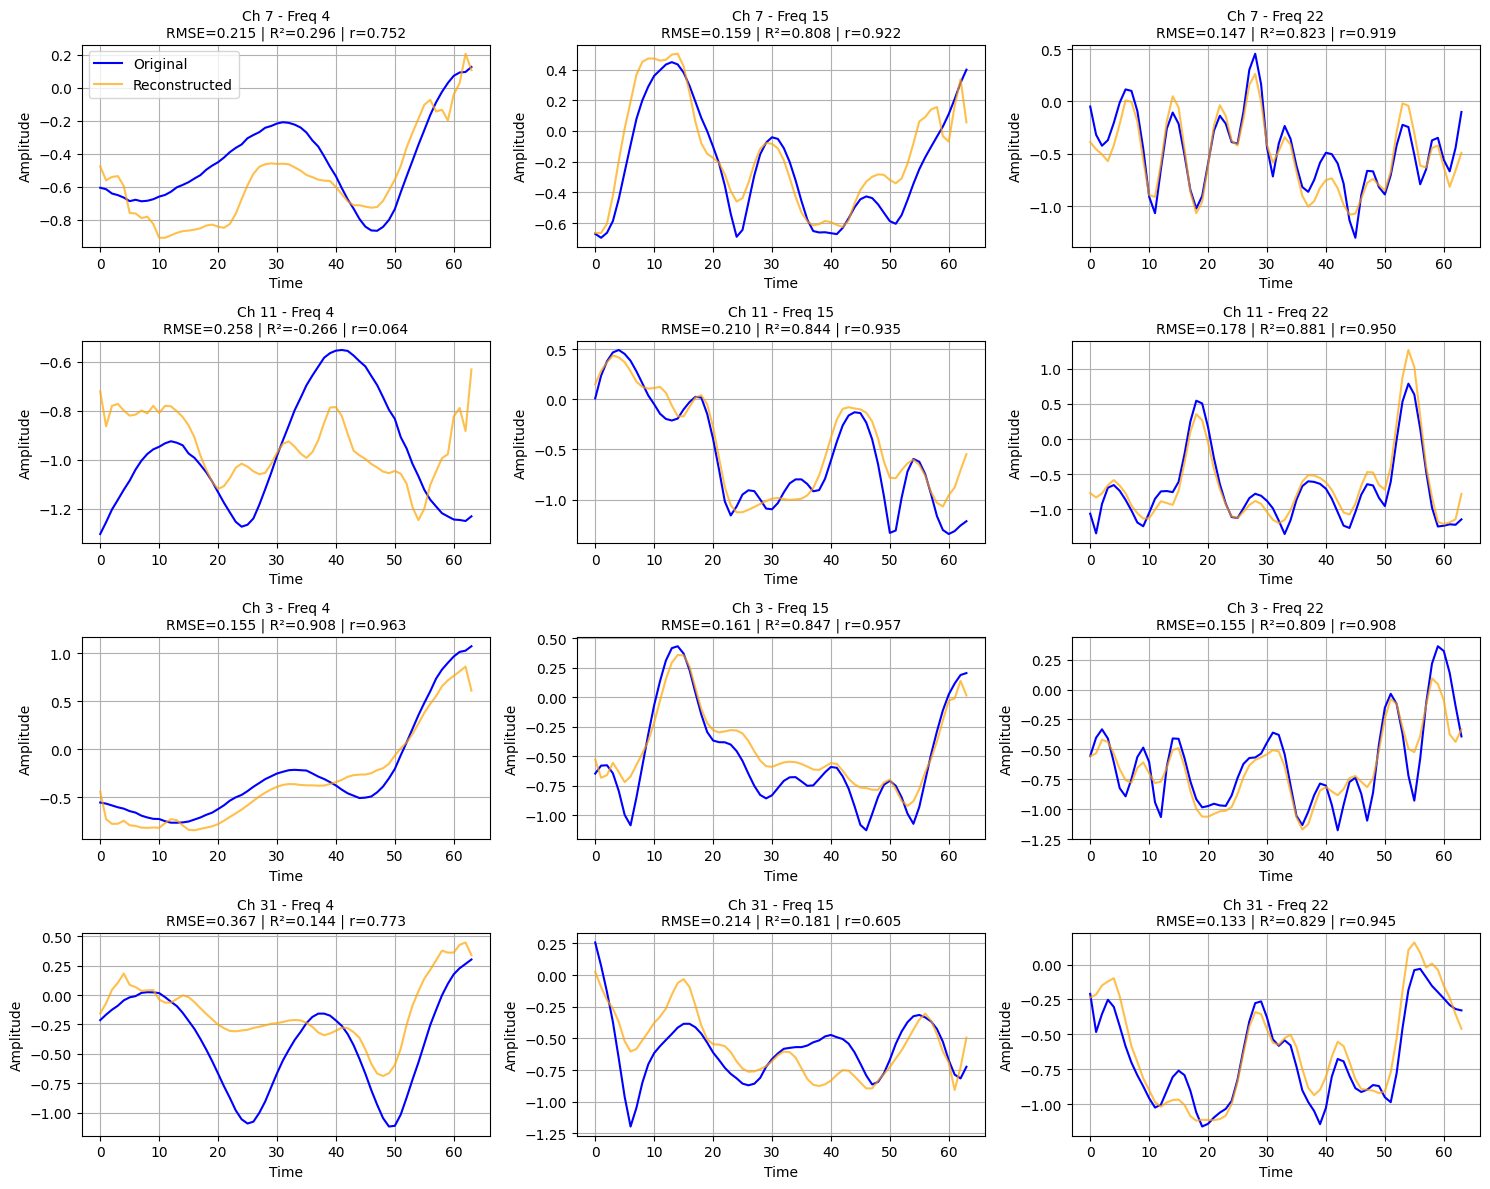

In [4]:
from packages.plotting.reconstruction_plots import plot_reconstruction_slices
import numpy as np

import torch
from packages.plotting.reconstruction_plots import plot_reconstruction_scatter

# --- Load model and parameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#model.load_state_dict(torch.load("/kaggle/working/MIEEG/model_backups/best_model_epoch_25.pt", map_location="cpu"))
model.eval()
# --- Prepare input data ---
input_data = next(iter(train_loader))  # Replace with your actual input
input_data = input_data.to(device)
# --- Get reconstruction ---
with torch.no_grad():
    reconstructed = model(input_data)
    if isinstance(reconstructed, tuple):
        reconstructed = reconstructed[0]

# --- Plot reconstruction scatter ---

i = np.random.randint(0, input_data.shape[0])
j = np.random.randint(0, input_data.shape[1])
plot_reconstruction_slices(input_data[i, j, ...], reconstructed[i, j, ...], freqs=[4, 15, 22])

In [1]:
config['epochs'] = 400
config ['EarlyStopping'] = {'patience': 50, 'min_delta': 0.01}
config['lr'] = 1e-4
train_model(model, train_loader=train_loader, val_loader=val_loader, loss_criterion=criterion, optimizer=optimizer, config=config, metrics={})

NameError: name 'config' is not defined

In [30]:
from packages.train.testing import autoencoder_test_plots
autoencoder_test_plots(model, val_loader, nsamples = 5)

torch.Size([7, 10, 25, 7, 5, 25])


/kaggle/working/MIEEG/packages/train/testing.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs).to(device)


TypeError: expected Tensor as element 0 in argument 0, but got tuple

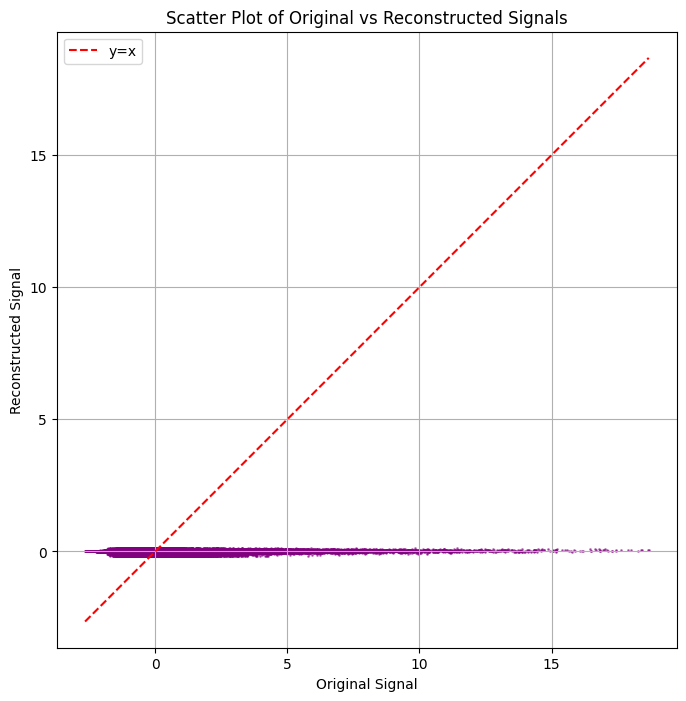

IndexError: index 30 is out of bounds for dimension 0 with size 7

In [17]:
from packages.plotting.reconstruction_plots import plot_reconstruction_slices
import numpy as np

import torch
from packages.plotting.reconstruction_plots import plot_reconstruction_scatter

# --- Load model and parameters ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#model.load_state_dict(torch.load("/kaggle/working/MIEEG/model_backups/best_model_epoch_25.pt", map_location="cpu"))
model.eval()
# --- Prepare input data ---
input_data = next(iter(val_loader))  # Replace with your actual input
input_data = input_data.to(device)
# --- Get reconstruction ---
with torch.no_grad():
    reconstructed = model(input_data)
    if isinstance(reconstructed, tuple):
        reconstructed = reconstructed[0]

# --- Plot reconstruction scatter ---
plot_reconstruction_scatter(input_data, reconstructed)

batch_size = config.get('batch_size', 31)
i = np.random.randint(0, batch_size)
if isinstance(reconstructed, tuple):
    reconstructed = reconstructed[0]
plot_reconstruction_slices(input_data[i,...], reconstructed[i,...], freqs=[4,15,22])